# Trabalho CNN

Aluno: Alexsandro Guilherme Thomas

# Redes Neurais Convolucionais


Nesta competição, você escreverá um algoritmo para classificar se as imagens contêm um cachorro ou um gato. Isso é fácil para humanos, cães e gatos. Seu computador terá um pouco mais de dificuldade. 

<img src='woof_meow.jpg' />


### Problema: Dada uma imagem, é um cachorro ou um gato?

Para essa tarefa, usaremos uma arquitetura de Rede Neural Convolucional. Essa arquitetura usa métodos de convolução para poder prever características específicas de uma imagem de acordo com o que aprende em um conjunto de treinamento. Por exemplo, podemos dizer que é possível perceber a diferença ao procurar bigodes em um gato ou focinho comprido em um cachorro. Mas uma Rede Neural Convolucional procura muitos outros recursos baseados no que temos em um conjunto de treinamento.

##### Conjunto de dados de treino:  2.000 imagens de cães e 2.000 imagens de gatos.

##### Conjunto de dados de validação: 500 imagens de cães e 500 imagens de gatos.

Conjunto de dados de teste: Teremos x imagens de cães e gatos.

Essa á uma questão onde os iniciantes tem muitas dúvidas. Por que precisamos de dados de treino, validação e teste? Usamos os dados de treino para treinar o algoritmo e então criar o modelo preditivo. Usamos os dados de validação, para avaliar o modelo durante o treinamento. Usamos os dados de teste para validar a performance do modelo já treinado, ou seja, apresentamos ao modelo dados que ele não viu durante o treinamento, a fim de garantir que ele é capaz de fazer previsões.

# **Vamos começar!**



## Importando as bibliotecas

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.preprocessing import image
import os.path

### Arquitetura da Rede Convolucional


<img src='arquitetura.png'/>

In [2]:
classificador = Sequential()
classificador.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',
                padding='same', input_shape=(224, 224, 3)))
classificador.add(BatchNormalization())
classificador.add(MaxPooling2D((2, 2)))
classificador.add(Dropout(0.2))  

classificador.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
classificador.add(BatchNormalization())
classificador.add(MaxPooling2D((2, 2)))
classificador.add(Dropout(0.25))

classificador.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
classificador.add(BatchNormalization())
classificador.add(MaxPooling2D((2, 2)))
classificador.add(Dropout(0.3))

classificador.add(Flatten())
classificador.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
classificador.add(BatchNormalization())
classificador.add(Dropout(0.35))
classificador.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
classificador.add(BatchNormalization())
classificador.add(Dropout(0.4))
classificador.add(Dense(2, activation='relu', kernel_initializer='he_uniform'))
classificador.add(BatchNormalization())
classificador.add(Dropout(0.5))
classificador.add(Dense(1, activation='sigmoid'))

classificador.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                      metrics = ['mean_absolute_error', 'accuracy'])

### Vamos gerar algumas imagens 

<img src= 'ImageGenerator.png' widht=300/>


### Normalizar as imagens

In [3]:
gerador_treinamento = ImageDataGenerator(rescale = 1./255,
                                         rotation_range = 7,
                                         horizontal_flip = True,
                                         shear_range = 0.2,
                                         height_shift_range = 0.07,
                                         zoom_range = 0.2)
gerador_teste = ImageDataGenerator(rescale = 1./255)

In [4]:
base_treinamento = gerador_treinamento.flow_from_directory('dataset/training_set',
                                                           target_size = (224, 224),
                                                           batch_size = 64,
                                                           class_mode = 'binary')

Found 4000 images belonging to 2 classes.


In [5]:
base_teste = gerador_teste.flow_from_directory('dataset/test_set',
                                               target_size = (224, 224),
                                               batch_size = 64,
                                               class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [6]:
classificador.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

## Treinamento

In [7]:
#Checar se já foi treinado
if os.path.exists("weights.best.hdf5") :
    classificador.load_weights("weights.best.hdf5")
else :
    #Definir callbacks
    checkpoint = ModelCheckpoint(filepath="weights.best.hdf5",monitor='mean_absolute_error', verbose=1, save_best_only=True, mode='min')

    es = EarlyStopping(monitor='mean_absolute_error', mode='min', verbose=1,patience=10)

    callbacks_list = [checkpoint,es]

    classificador.fit(base_treinamento, steps_per_epoch = 40,
                                epochs = 10, validation_data = base_teste,
                                validation_steps = 10, callbacks=callbacks_list)

## Teste *

In [8]:
imagem_teste = image.load_img('dataset/test_set/cachorro/dog.3969.jpg',
                              target_size = (224,224))

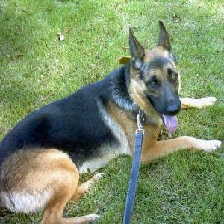

In [9]:
imagem_teste

In [10]:
imagem_teste = image.img_to_array(imagem_teste)
imagem_teste /= 255

In [11]:
imagem_teste = np.expand_dims(imagem_teste, axis = 0)

In [12]:
previsao = classificador.predict(imagem_teste)
previsao

array([[0.33348975]], dtype=float32)

In [13]:
base_treinamento.class_indices

{'cachorro': 0, 'gato': 1}

In [14]:
previsao = (previsao > 0.5)
previsao

array([[False]])

## Acurácia

In [15]:
base_acc = gerador_treinamento.flow_from_directory('dataset/validacao_set',
                                                    target_size = (224, 224),
                                                    batch_size = 5,
                                                    class_mode = 'binary')

Found 20 images belonging to 2 classes.


In [16]:
print(base_acc.class_indices)

{'cachorro': 0, 'gato': 1}


In [22]:
total = 0
hits = 0
for img, k in zip(base_acc, base_acc.classes) :
    total+=1
    img = np.expand_dims(img[0][0], axis = 0)
    previsao = classificador.predict(img) > 0.5
    if previsao==k : hits+=1

print(f"{hits}/{total}, {(hits/total)*100}%")

11/20, 55.00000000000001%
